In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import tensorflow
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import time
import sys
%matplotlib inline
import random
import copy

random.seed(a=0)

class GeneticPool(object):
    def __init__(
        self, 
        populationSize = 40, 
        mutationRate = 0.1, 
        ins = None,
        outs = None):

        self.populationSize = populationSize
        self.mutationRate = mutationRate
        self.optimizer = ['rmsprop', 'adam', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam']
        self.activation: ['relu', 'elu', 'tanh', 'sigmoid']
        self.poolInputNeurons = [4,8,12,16]
        self.poolHiddenLayer = [8,]
        
    def generatePopulation(self):
        self.chromosomes = []
        for _ in range(self.populationSize):
            c = self.generateChromosome()
            self.chromosomes += [c]
                      
    def generateChromosome(self):
        class Chromosome:
            LR = random.uniform(self.poolLR[0], self.poolLR[1])
            InputNeurons = self.poolInputNeurons[random.randint(1,len(self.poolInputNeurons))-1]          
            HiddenLayer = self.poolHiddenLayer[random.randint(1,len(self.poolHiddenLayer))-1]
            Error = 0
            pesoEnt = []
            pesoSal = []
        chromosome = Chromosome() 
        return chromosome
    

In [2]:
################################################################################
##                           LEER DATOS SERIE                                 ##
################################################################################

class TimeSeriesNN3():
    def __init__(self,STEPS_AHEAD ,NUMBER_TESTING ,PERCENTAGE_VALIDATION, SERIE, WINDOW):
        self.STEPS_AHEAD = STEPS_AHEAD
        self.WINDOW = WINDOW
        self.NUMBER_TESTING = NUMBER_TESTING
        self.PERCENTAGE_VALIDATION = PERCENTAGE_VALIDATION
        self.SERIE = SERIE
        self.SIZE = SERIE.shape[0]
        self.NUMBER_VALIDATION = 0
        self.NUMBER_TRAINING = self.SIZE - self.NUMBER_TESTING
        if (PERCENTAGE_VALIDATION != 0):
            self.NUMBER_VALIDATION = int(self.NUMBER_TRAINING/self.PERCENTAGE_VALIDATION)
        self.NUMBER_TRAINING_F = self.NUMBER_TRAINING - self.NUMBER_VALIDATION - self.WINDOW
    
    def divide_testing (self):
        return (self.SERIE[:self.NUMBER_TRAINING],self.SERIE[self.NUMBER_TRAINING:])
    
    def divide_validation (self,serie, random):
        experimentx = np.zeros((self.NUMBER_TRAINING - self.WINDOW , self.WINDOW))
        experimenty = np.zeros((self.NUMBER_TRAINING - self.WINDOW,1))
        cnt =  0
        cnt2 = 0
        for i in range (experimentx.shape[0]):
            cnt += cnt2
            for j in range (self.WINDOW):
                experimentx[i][j] = self.SERIE[cnt]
                cnt += 1
            experimenty[i] = self.SERIE[cnt + self.STEPS_AHEAD - 1]
            cnt = 0
            cnt2 += 1      
        if (random):
            experimentx = np.concatenate((experimentx, experimenty), axis=1)
            experimentx = np.random.permutation(experimentx)
            experimentx, experimenty = np.hsplit(experimentx,[-1])   
        
        if (self.PERCENTAGE_VALIDATION == 0):
            return (experimentx, experimenty, experimentx, experimenty)
        else:
            return (experimentx[:self.NUMBER_TRAINING_F], experimenty[:self.NUMBER_TRAINING_F], experimentx[self.NUMBER_TRAINING_F:], experimenty[self.NUMBER_TRAINING_F:])
    
    
    def batch (self, boolean):
        x,p = self.divide_testing()
        w,x,y,z =self.divide_validation(x,boolean)
        return (w,x,y,z,p)
            

            

In [4]:
PERCENTAGE_VALIDATION = 10
NUMBER_TESTING        = 18
STEPS_AHEAD           = 1
WINDOW = 5
training_data = pd.read_excel("NN3_FINAL_DATASET_WITH_TEST_DATA.xlsx",sheet_name="Hoja 1")
Serie_1 = training_data["Serie 12"]
Serie_1_ORIGINAL = training_data["Serie 12"]
MINIMO = np.amin(Serie_1)
Serie_1 = (abs(MINIMO)+ Serie_1)
MAXIMO = np.amax(Serie_1)
Serie_1 = Serie_1 / MAXIMO

In [5]:
class BackPropagation:
    def __init__(self, iteraciones, LR, neurons, window_size, prediction_size,train_data_x,train_data_y,validate_data_x,validate_data_y):
        iterations = iteraciones
        LR = LR
        neurons = int(neurons)
        window_size = int(window_size)
        prediction_size = prediction_size
        train_size = train_data_x.shape[0]
        validate_size = validate_data_x.shape[0]
        #########################################################
        a_0 = tf.placeholder(tf.float32, [1, window_size])
        y = tf.placeholder(tf.float32, [1, prediction_size])
        
        m1 = tf.Variable( tf.random_uniform( [window_size, neurons] , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
        b1 = tf.Variable( tf.random_uniform( [neurons]   , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
        h1 = tf.sigmoid( tf.matmul( a_0,m1 ) + b1 )

        # Layer 2 = the 3x1 sigmoid output
        m2 = tf.Variable( tf.random_uniform( [neurons, prediction_size] , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
        b2 = tf.Variable( tf.random_uniform( [prediction_size]   , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
        y_out = tf.sigmoid( tf.matmul( h1,m2 ) + b2 )


        ### loss
        # loss : sum of the squares of y0 - y_out
        loss = tf.reduce_sum( tf.square( y - y_out ) )

        # training step : gradient decent (1.0) to minimize loss
        step = tf.train.GradientDescentOptimizer(LR).minimize(loss)
        
        with tf.Session() as sess:
            sess.run( tf.global_variables_initializer() )
            df = []
            grafica = []
            ##############################################################################################
            for i in range(iterations):
                error_final = 0
                for j in range (train_size):
                    batch_xs = (train_data_x[j])
                    batch_ys = (train_data_y[j])
                    batch_xs = np.reshape(batch_xs,(1,window_size))
                    batch_ys = np.reshape(batch_ys,(1,1))
                    sess.run([step], feed_dict = {a_0: batch_xs, y : batch_ys})
                for j in range (validate_size):
                    batch_xs = (validate_data_x[j])
                    batch_ys = (validate_data_y[j])
                    batch_xs = np.reshape(batch_xs,(1,window_size))
                    batch_ys = np.reshape(batch_ys,(1,1))
                    error = loss.eval(feed_dict = {a_0: batch_xs, y : batch_ys})
                    error_final += error
                if(i<=5):
                    comp1=error_final/validate_size
                    df.append(error_final/validate_size)
                    self.final_result = error_final/validate_size
                else:
                    if(comp1<error_final/validate_size):
                        break
                    else:
                        comp1=error_final/validate_size
                        df.append(error_final/validate_size)
                        self.final_result = error_final/validate_size
                
            for j in range (validate_size):
                    batch_xs = (validate_data_x[j])
                    batch_ys = (validate_data_y[j])
                    batch_xs = np.reshape(batch_xs,(1,window_size))
                    batch_ys = np.reshape(batch_ys,(1,1))
                    salida = y_out.eval(feed_dict = {a_0: batch_xs, y : batch_ys})
                    grafica.append(salida[0][0])
            self.resultado = df
            self.grafica = grafica
            sess.close()

In [221]:
def StartGenetic():
    a = GeneticPool()
    a.generatePopulation()
    listIndex = []
    for i in range (len(a.chromosomes)):
        Serie1 = TimeSeriesNN3(STEPS_AHEAD ,NUMBER_TESTING ,PERCENTAGE_VALIDATION, Serie_1,int(a.chromosomes[i].InputNeurons))
        tx, ty, vx, vy, p = Serie1.batch(False)
        b = BackPropagation (250,a.chromosomes[i].LR,int(a.chromosomes[i].HiddenLayer*(a.chromosomes[i].InputNeurons)), int(a.chromosomes[i].InputNeurons), 1, tx, ty, vx, vy)
        #b.resultado.plot()
        a.chromosomes[i].Error = b.final_result
    return a.chromosomes

def Fitness(num, obj):
    listIndex = []   
    for i in range (len(obj)):
        if i == 0:
            listIndex = [i]
        elif len(listIndex) <= num -1 :
            if obj[listIndex[len(listIndex)-1]].Error <= obj[i].Error:
                listIndex.append(i)
            else :
                for j in range (len(listIndex),-1,-1):
                    if j == 0:
                        listIndex.insert(0,i)
                        break
                        
                    elif obj[listIndex[j-1]].Error <= obj[i].Error:
                        listIndex.insert(j,i)
                        break
        else :
            if obj[listIndex[len(listIndex)-1]].Error >= obj[i].Error:
                for j in range (len(listIndex),-1,-1):
                    if j == 0:
                        listIndex.insert(0,i)
                        listIndex.pop()
                        break
                        
                    elif obj[listIndex[j-1]].Error <= obj[i].Error:
                        listIndex.insert(j,i)  
                        listIndex.pop()
                        break
    matingPool = []
    for i in listIndex:
        matingPool.append(obj[i])
    return matingPool
        
        
        

In [222]:
def swap(w1,w2):
    children = copy.deepcopy(w1)
    r = random.randint(0,1)
    if r == 0:
        children.HiddenLayer = w2.HiddenLayer
    else :
        children.LR = w2.LR
        children.InputNeurons = w2.InputNeurons
   # print(children.LR)
    return children

def CrossOver(matingPool,population):
    
    percentage = []
    total_error = 0
    suma = 0
    roulette = []
    newGeneration = []
    
    for i in matingPool:
        percentage.append(1/i.Error)
        total_error += 1/i.Error
    for i in range(len(matingPool)):
        percentage[i] = round((percentage[i]/total_error)*100)
    
    for i in percentage:
        suma += i
    
    if suma > 100:
        percentage[len(percentage)-1] -= suma - 100
    
    elif suma < 100:
        percentage[0] += 100 - suma

    
    var = 0
    for i in percentage:
        for j in range (int(i)):
            roulette.append(matingPool[var])
        var += 1
    
    for i in range(population):
        winner1 = random.randint(0,len(roulette)-1)
        winner2 = winner1
        while (winner2 == winner1):
            winner2 = random.randint(0,len(roulette)-1)
        #print(2, matingPool[0].LR,matingPool[1].LR)
        newGeneration.append(swap(roulette[winner1],roulette[winner2]))
    return newGeneration

    
    

In [7]:
fg = 0

In [223]:

def main ():
    print ("entre")
    x = StartGenetic()
    print ("sale")
    b = Fitness(10,x)
    fg=x
    z = CrossOver(b,40)
    cnt = 0
    for epocas in range (5):
        print(epocas)
        for i in z:
            Serie1 = TimeSeriesNN3(STEPS_AHEAD ,NUMBER_TESTING ,PERCENTAGE_VALIDATION, Serie_1,int(i.InputNeurons))
            tx, ty, vx, vy, p = Serie1.batch(False)
            er = BackPropagation(250,i.LR,int(i.HiddenLayer*(i.InputNeurons)),int(i.InputNeurons),1,tx,ty,vx,vy)
            i.Error = er.final_result
            cnt += 1
            print(cnt)
        b = Fitness(10,z)
        z = CrossOver(b,40)
    return z

In [224]:
z = main()
z = Fitness(5,z)



entre
0.6053084
1.0
0.5956511
0.6568899
0.6557057
0.6159378
0.6599818
0.6489746
0.62946296
0.6295002
0.64908475
0.6075662
0.6432927
0.6579025
0.64594597
0.6125495
0.9999944
0.64976454
0.63396204
0.9999993
0.6477926
0.6532374
0.9999976
0.6641101
0.63372684
0.636337
0.9999962
0.6301199
0.6488349
0.6448885
0.6425307
0.64105165
0.6555455
0.6301678
0.6482892
0.65539896
0.6329173
0.67062974
0.6303618
0.65764457
sale
0
0.61468285
1
0.62391555
2
1.0
3
0.62078667
4
0.99945873
5
0.645905
6
0.9999988
7
0.6242595
8
0.62851644
9
0.99999607
10
0.64071065
11
0.63184065
12
0.6076819
13
0.6078574
14
0.6304326
15
0.6287257
16
0.9999939
17
0.63090634
18
0.6245576
19
0.62970674
20
0.61449325
21
0.61712635
22
0.60812414
23
0.9999995
24
0.6386076
25
0.6173102
26
0.64261687
27
1.0
28
0.6171654
29
0.99992466
30
0.60940427
31
0.6335492
32
0.61331844
33
0.6375953
34
0.6140358
35
0.6305454
36
0.99997294
37
0.62712693
38
0.6298607
39
0.63316125
40
1
0.6144293
41
0.6250746
42
0.61580026
43
0.62984306
44
0.6140521


In [229]:
for i in z:
    print(i.LR, i.HiddenLayer, i.InputNeurons)

0.4213380216584809 1.5 8
0.4213380216584809 1.5 8
0.4949036804132052 1.5 8
0.2770773436585364 1.5 12
0.2770773436585364 1.5 12


In [6]:
Serie1 = TimeSeriesNN3(1 ,13 ,10, Serie_1,8)
tx, ty, vx, vy, p = Serie1.batch(False)
b = BackPropagation (15,0.4213380216584809,12, 8, 1, tx, ty, vx, vy)


In [7]:
pr = (np.array(b.grafica))


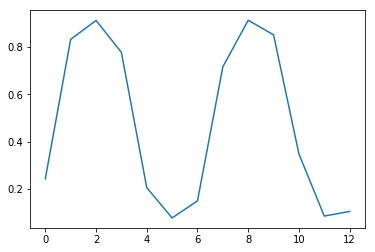

In [8]:
plt.plot(pr)
plt.show()

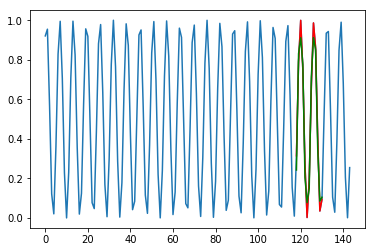

In [9]:
pp = np.array(pr[-Serie1.NUMBER_VALIDATION:])
pp = pp.reshape([Serie1.NUMBER_VALIDATION,1])
plt.plot(Serie_1)
plt.plot(np.arange(Serie1.NUMBER_TRAINING_F+Serie1.WINDOW,Serie1.NUMBER_TRAINING),vy.reshape(Serie1.NUMBER_VALIDATION),"r")
plt.plot(np.arange(Serie1.NUMBER_TRAINING_F+Serie1.WINDOW,Serie1.NUMBER_TRAINING),pp[-Serie1.NUMBER_VALIDATION:],"g")
plt.show()

In [11]:
b.final_result

0.003143987813158534

In [204]:
for i in z:
    print (i.LR, i.Error, i.InputNeurons, i.HiddenLayer)

0.47860102166799845 0.00016593130093648747 8 1
0.47860102166799845 0.00016593130093648747 8 1
0.47860102166799845 0.00016593130093648747 8 1
0.47860102166799845 0.00016593130093648747 8 1
0.47860102166799845 0.00016593130093648747 8 1


In [ ]:
round(2.3)

In [ ]:
class ValidateBP:
    def __init__(self, iteraciones, LR, neurons, window_size, dataRetoque, dataSalida, pesoEntrada, pesoEscondido, training):
        iterations = iteraciones
        LR = LR
        neurons = int(neurons)
        window_size = int(window_size)
        pesoEnt = pesoEntrada
        pesoHid = pesoEscondido
        dataRetoque = dataRetoque
        dataSalida = dataSalida
        training =  training

        #########################################################
        a_0 = tf.placeholder(tf.float32, [1, 4])
        y = tf.placeholder(tf.float32, [1, 1])
        w_1 =  tf.Variable(pesoEntrada)
        w_2 =  tf.Variable(pesoEscondido)
        ##########################################################
        def sigma(x):
            return tf.div(tf.constant(1.0),
                          tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

        def sigmaprime(x):
            return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

        ##############################################################
        z_1 = tf.matmul(a_0, w_1)
        a_1 = sigma(z_1)
        z_2 = tf.matmul(a_1, w_2)
        a_2 = sigma(z_2)
        diff = tf.subtract(a_2, y)
        ###############################################################
        d_z_2 = tf.multiply(diff, sigmaprime(z_2))
        d_b_2 = d_z_2
        d_w_2 = tf.matmul(tf.transpose(a_1), d_z_2)
        d_a_1 = tf.matmul(d_z_2, tf.transpose(w_2))
        d_z_1 = tf.multiply(d_a_1, sigmaprime(z_1))
        d_b_1 = d_z_1
        d_w_1 = tf.matmul(tf.transpose(a_0), d_z_1)
        ###############################################################
        eta = tf.constant(LR)
        cost = tf.multiply(diff, diff)
        cost = tf.sqrt(cost)
        #step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
        step = [
            tf.assign(w_1,
                    tf.subtract(w_1, tf.multiply(eta, d_w_1)))
          , tf.assign(w_2,
                    tf.subtract(w_2, tf.multiply(eta, d_w_2)))
        ]
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        df = pd.DataFrame(columns=['error'])
        comp1=0
        ##############################################################################################
        if (training):
            for i in range(iterations):
                error_final = 0
                batch_xs = dataRetoque
                batch_ys = dataSalida
                batch_xs = np.reshape(batch_xs,(1,4))
                batch_ys = np.reshape(batch_ys,(1,1))
                a,w1,w2 = sess.run([step,w_1,w_2], feed_dict = {a_0: batch_xs, y : batch_ys})
                pesoEntrada = w_1
                pesoEscondido = w_2
            #self.pesoEntrada = pesoEntrada.eval()
            #self.pesoEscondido = pesoEscondido.eval()
        else:
            error_final = 0
            batch_xs = dataRetoque
            batch_ys = dataSalida
            batch_xs = np.reshape(batch_xs,(1,4))
            batch_ys = np.reshape(batch_ys,(1,1))
            a = sess.run([a_2], feed_dict = {a_0: batch_xs, y : batch_ys})
            self.salida = a
        sess.close()

In [ ]:
def  llenarData(pesoEntrada2,pesoEscondido2):
    pesoEntrada = tf.Variable(pesoEntrada2)
    pesoEscondido = tf.Variable(pesoEscondido2)
    data = pd.read_excel("4years-2013-2017.xls", one_hot=True)
    data = (data["Average"])
    data = np.array(data)/np.max(data)
    valores = []
    valoresVer =[]
    for i in range(len(data) - 5):
        dataRetoque = data[i:i+4]
        dataSalida = data[i+4]
        newBP =ValidateBP(0,0.40270888567949814, 1.5*4, 4, dataRetoque, dataSalida, pesoEntrada, pesoEscondido, True)
        #pesoEntrada=newBP.pesoEntrada
        #pesoEscondido=newBP.pesoEscondido
        dataRetoque = data[i+1:i+5]
        dataSalida = data[i+5]
        salida = ValidateBP(1,0.40270888567949814, 1.5*4, 4, dataRetoque, dataSalida, pesoEntrada, pesoEscondido, False).salida
        valores.append(salida[0][0][0])
        valoresVer.append(dataSalida)
        print(i)
    return valores, valoresVer

In [ ]:
a, b  = llenarData(z[0].pesoEnt,z[0].pesoSal)

In [ ]:
a, b  = llenarData(z[0].pesoEnt,z[0].pesoSal)
a = pd.DataFrame({'Prediccion':a})
b = pd.DataFrame({'Real':b})
data = pd.read_excel("4years-2013-2017.xls", one_hot=True)
data = (data["Average"])
maxi = np.max(data)
a = a * maxi
b = b * maxi
c = pd.concat([a,b], axis = 1)
c.plot()

In [ ]:
b = a['Predicción']
lista = []
for i in b:
    lista.append((i[0][0][0]))


In [ ]:
lista2 = pd.DataFrame({'prediction':lista})
lista2.plot()


In [ ]:
 intento = ValidateBP(20, 0.247295355366197,2.5*16,3,1,12,forGraph.pesosEnt, forGraph.pesosHid)

In [ ]:
vars(intento)

In [ ]:
z2 = Fitness(5,z)

In [ ]:
vars(z2[2])

In [ ]:
#2.5 20 0.012368505258660532
forGraph=BackPropagation(20, 0.247295355366197,2.5*16,3,1,180)

In [ ]:
vars(forGraph)

In [ ]:
#precioBarril = pd.read_excel("precioBarril.xls")
#data = (precioBarril["Average"])
#print(np.max(data))

# forGraph.resultado.plot()


In [ ]:
forGraph.resultado.plot()

In [ ]:
#print(0.170855*117.4)
#print((0.168914794921875)/26)
#print(81.730599844-61.9)

In [ ]:
i = [1]
i.append(2)
i

In [51]:
# Layer 1 = the 2x3 hidden sigmoid
m1 = tf.Variable( tf.random_uniform( [2,3] , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
b1 = tf.Variable( tf.random_uniform( [3]   , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
h1 = tf.sigmoid( tf.matmul( x0,m1 ) + b1 )

# Layer 2 = the 3x1 sigmoid output
m2 = tf.Variable( tf.random_uniform( [3,1] , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
b2 = tf.Variable( tf.random_uniform( [1]   , minval=0.1 , maxval=0.9 , dtype=tf.float32  ))
y_out = tf.sigmoid( tf.matmul( h1,m2 ) + b2 )


### loss
# loss : sum of the squares of y0 - y_out
loss = tf.reduce_sum( tf.square( y0 - y_out ) )

# training step : gradient decent (1.0) to minimize loss
train = tf.train.GradientDescentOptimizer(1.0).minimize(loss)


### training
# run 500 times using all the X and Y
# print out the loss and any other interesting info
with tf.Session() as sess:
  sess.run( tf.global_variables_initializer() )
  for step in range(500) :
    sess.run(train)

  results = sess.run([m1,b1,m2,b2,y_out,loss])
  labels  = "m1,b1,m2,b2,y_out,loss".split(",")
  for label,result in zip(*(labels,results)) :
    print ""
    print label
    print result

print ""

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("")? (<ipython-input-51-640097a0f8a9>, line 31)